In [2]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from ipywidgets import Image
from IPython import display
import numpy as np
from scipy.spatial import Delaunay
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib widget

In [3]:
w1data = pd.read_csv("nfl-big-data-bowl-2023/week1.csv")
w2data = pd.read_csv("nfl-big-data-bowl-2023/week2.csv")
w3data = pd.read_csv("nfl-big-data-bowl-2023/week3.csv")
players_background = pd.read_csv("BigDataBowl2023/data2023/players.csv", index_col='nflId')
madden_df = pd.read_csv("BigDataBowl2023/merged_df.csv")
median_df = pd.read_csv("BigDataBowl2023/all_pos_df.csv", index_col=0)

In [3]:
print(len(w1data['playId'].unique()))

1021


In [4]:
def collect_game_info(weekdf, playId, saved=False):
    
    #slice df to single play
    playdf = weekdf.loc[weekdf["playId"] == playId]
    #reorder playdf so that they are in the right frame order
    playdf = playdf.sort_values(by = "frameId")
    if saved:
        playdf.to_csv(f'Play{playId}Frames.csv')
    return playdf

In [22]:
def gaussian(x):
    return np.exp(-(((x**2)-(2*x)+1)/(0.4*x)))

In [24]:
def val_check(x,range):
    if x < range[0]:
        return 0
    elif x > range[1]:
        return 0
    else:
        return 1

In [25]:
print(gaussian(1))

1.0


In [41]:
def find_best_player(weekdf,playId,resolution,madden_df,median_df,players_background):
    play = collect_game_info(weekdf, playId)
    
    madden_df.loc[:, 'nflId'] = madden_df['nflId'].astype('int64')
    madden_df = madden_df.set_index('nflId')
    play_df = play.dropna()
    ball_df = play[play['team'] == 'football']
    play_df.loc[:, 'frameId'] = play_df['frameId'].astype('int')
    play_df.loc[:, 'nflId'] = play_df['nflId'].astype('int64')
    player_df = play_df.set_index(['nflId', 'frameId'])
    ball_df = ball_df.set_index(['frameId'])

        # Stuff for plotting
    num_frames = len(play_df['frameId'].unique())
        #self.num_players = len(self.play_df['jerseyNumber'].unique())
    teams = player_df['team'].unique()
    #xrange = (player_df['x'].min()-10, player_df['x'].max()+10)
    #yrange = (player_df['y'].min()-10, player_df['y'].max()+10)
    player_best_scores = {}
    player_speeds = {}
    player_catchs = {}
    
    ##megauhohthis is so bad
    #getting attacker and defener names
    idx = pd.IndexSlice
    player_frame_df = player_df.loc[idx[:, 1+1], :].droplevel(-1)
    for nflId, player in player_frame_df.iterrows():
            pos = players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]
                direction = player['playDirection']
    xrange = (player_df['x'].min()-10, player_df['x'].max()+10)
    yrange = (player_df['y'].min()-10, player_df['y'].max()+10)
    attackers = player_frame_df[player_frame_df['team']==qb_team]
    defenders = player_frame_df[player_frame_df['team']!=qb_team]
    for nflId, player in attackers.iterrows():#collecting speed scores + generating dicts of info
                player_best_scores[nflId] = 0
                player_position = players_background.loc[nflId]['officialPosition']
                if nflId in madden_df.index:
                                player_stats = madden_df.loc[nflId]
                else:
                                player_stats = median_df.loc[player_position]
                player_speeds[nflId] = player_stats['Speed'] + player_stats['Acceleration'] + player_stats['Agility']/3
                player_catchs[nflId] = player_stats['Catching']
    for nflId, player in defenders.iterrows():
                player_position = players_background.loc[nflId]['officialPosition']
                if nflId in madden_df.index:
                                player_stats = madden_df.loc[nflId]
                else:
                                player_stats = median_df.loc[player_position]
                player_speeds[nflId] = player_stats['Speed'] + player_stats['Acceleration'] + player_stats['Agility']/3
        # Determine if the QB has the ball still                
    def if_last_frame(qbx, qby, ballx, bally):
        x_dis = qbx - ballx
        y_dis = qby - bally
        
        if ((x_dis)**2 + (y_dis)**2) < 0.5:
            is_final_frame = True
        else:
            is_final_frame = False
            
        return is_final_frame 
        
    is_final_frame = False
    final_frame = num_frames + 1
    
    # Loop from final frame to find the frame QB throws
    while is_final_frame == False:
        final_frame -= 1
        i = final_frame
        idx = pd.IndexSlice
        player_frame_df = player_df.loc[idx[:, i], :].droplevel(-1)
        for nflId, player in player_frame_df.iterrows():
            pos = players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]
                # print(qbx, qby)
                
        ball_frame_df = ball_df.loc[i]
        ballx, bally = ball_frame_df[['x', 'y']]
        # print(ballx, bally)
        # print('Distance ball moved = '+ str(ball_frame_df['dis']))
        
        is_final_frame = if_last_frame(qbx, qby, ballx, bally)
        # print(final_frame, is_final_frame)
        
    final_frame_list = range(final_frame-1,final_frame+1)

    for frame in [final_frame]:
        i = frame
        idx = pd.IndexSlice
        player_frame_df = player_df.loc[idx[:, i+1], :].droplevel(-1)
        #ball_frame_df = ball_df.loc[i+1]
        #ball_frame_df = ball_df.loc[i+1].to_frame().transpose() # the hatred towards pandas I have in this instant is unquantifiable with words
        #ball_frame_df['nflId'] = 'football'
        #ball_frame_df.set_index('nflId', inplace=True)

        # Find the nflId of the QB (theres probably a better way to do this but idk it)
        for nflId, player in player_frame_df.iterrows():
            pos = players_background.loc[nflId]['officialPosition']
            if pos =='QB':
                qb_Id = nflId
                qb_team = player['team']
                qbx, qby = player[['x', 'y']]


        # Sort the players into attackers and defenders
        attackers = player_frame_df[player_frame_df['team']==qb_team]
        defenders = player_frame_df[player_frame_df['team']!=qb_team]

        receiver_ratings = {'nflId':[], 'receiver rating':[]}

        qb_stats = madden_df.loc[qb_Id]

        throw_score = qb_stats['Throw On The Run'] + qb_stats['Throw Under Pressure'] + qb_stats['Throw Power'] # !!!wowowowow

        for x in np.arange(xrange[0],xrange[1]+resolution,resolution):#loop over xcoords
                for y in np.arange(yrange[0],yrange[1]+resolution,resolution):#loop over ycoords
                    min_dist = 1000000 # big
                    score = 0 # how good the space is too pass to
                    for nflId, player in defenders.iterrows():
                        dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2) / player_speeds[nflId] # weighted distance using speeds
                        if dist_2_point < min_dist:
                            min_dist = dist_2_point#results in smallest dist from defending player
                    nearest_def_dist = min_dist
                    for nflId, player in attackers.iterrows():
                        #wr,te,fb,rb,
                        player_position = players_background.loc[nflId]['officialPosition']
                        if player_position in ["WR", "TE", "FB", "RB"]:
                            
                                
                            dist_2_point = np.sqrt((x-player['x'])**2+ (y-player['y'])**2)/ player_speeds[nflId]
                            
                            if dist_2_point < min_dist: #only if attacking player is closer to point than defending player
                                #if nflId == 42347:
                                #   print(dist_2_point,min_dist)
                                min_dist = dist_2_point
                                throw_dist = np.sqrt((x-qbx)**2 + (y-qby)**2)
                                
                                
                                if throw_dist >= 20:
                                    throw_score += qb_stats['Throw Acc Deep']
                                elif throw_dist >=10:
                                    throw_score += qb_stats['Throw Acc Mid']
                                else:
                                    throw_score += qb_stats['Throw Acc Short']
                                # Average the throw score over the 4 metrics used
                                throw_score /= 4 # !!!
                                #score defined as: yard gain * 'chance of catching' (losely defined as throwscore X catchscore) * tanh(time ball takes to reach point/ time player takes to reach points)
                                #tanh thing a metric of will the player reach the catching zone before the ball if both going at max speed
                                if direction == "left":
                                    yard = qbx-x
                                elif direction == "right":
                                    yard = x-qbx 
                                score =(yard)*np.tanh(100*nearest_def_dist) *np.tanh(throw_score*player_catchs[nflId]/10000)*np.tanh((throw_dist/(3*qb_stats['Throw Power']))/(min_dist/player_speeds[nflId]))#throw speed : player speed = roughly 3:1
                                
                                if score > player_best_scores[nflId]:
                                    
                                    player_best_scores[nflId] = score
            #for Id in player_best_scores:
           #     receiver_ratings['nflId'].append(Id)
           #     receiver_ratings['receiver rating'].append(player_best_scores[Id])
    top5Players = []
    topscores = []
    sorted_dict = dict(sorted(player_best_scores.items(), key=lambda item: item[1], reverse=True))
    for key in list(sorted_dict.keys()):
           top5Players.append(key)

           #topscores.append(sorted_dict[key])
    return top5Players, topscores
        

find_best_player(w1data,137,1,madden_df,median_df,players_background)

    

([42347, 43293, 46206, 45532, 52425, 52554, 47873, 43424, 37082, 42654, 46119],
 [27.950186020886232,
  4.6794275288002005,
  4.511277992982881,
  3.742377546342522,
  3.043348885940939,
  0,
  0,
  0,
  0,
  0,
  0])

In [42]:
def run_a_week(weekdf,weeknum):
    list_of_plays = weekdf['playId'].unique()
    #list_of_plays= list_of_plays[:20]
    with open(f'week{weeknum}tanhbestPlayer.csv', 'w', newline='') as f:
            write = csv.writer(f)
            write.writerow(['playId','nflId','2nd','3rd','4th','5th','6rd','7th','8th','9rd','10th','11th'])
    for playId in list_of_plays:
        try:
            best_players, best_scores = find_best_player(weekdf,playId,1,madden_df,median_df,players_background)

            with open(f'week{weeknum}tanhbestPlayer.csv', 'a+', newline='') as f:
                        write = csv.writer(f)
                        write.writerow([playId,best_players[0], best_players[1], best_players[2], best_players[3], best_players[4],best_players[5], best_players[6], best_players[7], best_players[8], best_players[9],best_players[10]])
                        #write.writerow([playId,best_scores[0], best_scores[1], best_scores[2], best_scores[3], best_scores[4], best_scores[5],best_scores[6], best_scores[7], best_scores[8],best_scores[9], best_scores[10]])
        
        except: 
            print(f'mega died for playId {playId}')
            with open(f'week{weeknum}tanhbestPlayer.csv', 'a+', newline='') as f:
                        write = csv.writer(f)
                        write.writerow([playId,'Error','Error','Error','Error','Error'])

In [43]:
run_a_week(w1data,1)

mega died for playId 282
mega died for playId 410
mega died for playId 559
mega died for playId 583
mega died for playId 764
mega died for playId 788


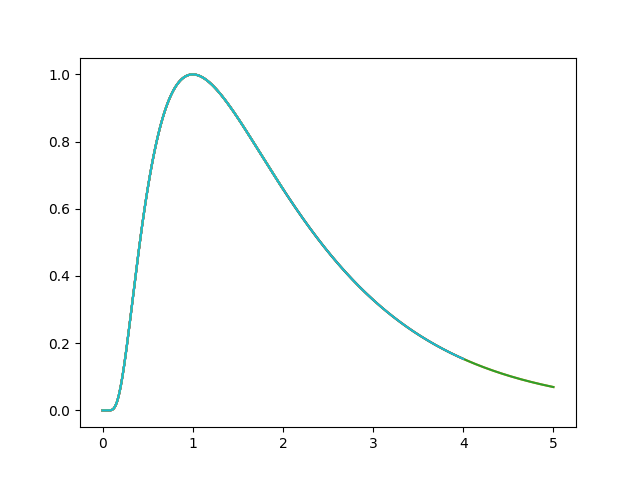

<function matplotlib.pyplot.clf()>

In [12]:
#make gaussian plot
x = np.linspace(0,4,200)
y = gaussian(x)
plt.plot(x,y)
plt.show()
plt.clf